<a id='section_id1'></a>
# BOM Weather

### A project evaluating the Persistence Model against the AUS Bureau of Meteorology.
We often get a 7 day weather forecast but don't often go back to see how accurate the predictions were for 7 days ago.   
This project looks to explore how accurate the weather forecast is according to a what is known as the Persistence Model.
The Persistence Model hypothesis for the weather domain is that "The weather tomorrow will be the same as today",   
or in mathematical terms Weather(t+1) = Weather(t), (t being today, or chosen point in time).

The BOM forecasts are known to be very accurate for t = 1,2 and 3 days into the future, so this project will evaluate the whole 7 day forecast.

The persistence model, also called the naïve predictor, is often used as a reference as it is a good ground estimation of other algorithms,and often used as a reference for determining the skill factor of a competing forecast model.   

The second part of this project will try to predict the weather, using the persistence model as a feature, giving some adjustment to standard forcasting models Facebook prophet and Random Forrest trained on historical data.

All data is available for free via the BOM website and examples are stored in the repository.

[Click here for EDA notebook locally](eda.ipynb#section_id1)   
[Click here for EDA notebook GitHub](https://github.com/bfgdigital/BOM_Weather/blob/main/notebooks/eda.ipynb)

**Imports**

In [1]:
import pandas as pd
import numpy as np
import requests
from matplotlib import pyplot as plt
import datetime as dt

Establish a date for today

In [2]:
today = dt.date.today()
# today = today.strftime("%Y-%m-%d")

yesterday = dt.date.today() - pd.DateOffset(days=1)
# yesterday = yesterday.strftime("%Y-%m-%d")

tomorrow = dt.date.today() + pd.DateOffset(days=1)
# tomorrow = tomorrow.strftime("%Y-%m-%d")

day_after_tomorrow = dt.date.today() + pd.DateOffset(days=2)
# day_after_tomorrow = day_after_tomorrow.strftime("%Y-%m-%d")

print(f'Yesterdays\'s date was: {yesterday.date()}')
print(f'Today\'s date is: {today}')
print(f'Tomorrows\'s date is: {tomorrow.date()}')
print(f'Day after that is: {day_after_tomorrow.date()}')

Yesterdays's date was: 2020-10-13
Today's date is: 2020-10-14
Tomorrows's date is: 2020-10-15
Day after that is: 2020-10-16


### DATA Sources 
- Data Comes From: ftp://ftp.bom.gov.au/anon/gen/fwo/
- Melbourne Forecast File: ftp://ftp.bom.gov.au/anon/gen/fwo/IDV10450.xml

The url for the BOM API is:
https://api.weather.bom.gov.au/v1/locations/r1r143/forecasts/daily   
Be Aware that the update is adjusted every 10mins.

In [3]:
locations = {
'LakeEildon' : 'https://api.weather.bom.gov.au/v1/locations/r1ru3qn/forecasts/daily',
'FallsCreek' : 'https://api.weather.bom.gov.au/v1/locations/r32wr3e/forecasts/daily',
'Mildura' : 'https://api.weather.bom.gov.au/v1/locations/r1vjdbz/forecasts/daily',
'Corryong' : 'https://api.weather.bom.gov.au/v1/locations/r394jdk/forecasts/daily',
'WilsonsProm' : 'https://api.weather.bom.gov.au/v1/locations/r3046k1/forecasts/daily',
'Melbourne' : 'https://api.weather.bom.gov.au/v1/locations/r1r143/forecasts/daily',
} # Melbourne last so it will be used for this iteration of the project.

**Save full forecast for future reference and development**

In [4]:
for name,url in locations.items():
    response = requests.get(url)
    weather_dict = response.json() # format as json
    latest_forecast = weather_dict
    api_forecast = pd.DataFrame(latest_forecast['data'])
    api_forecast.index=api_forecast['date']
    filename = '../data/forecast_records/forecast_' + str(name) + '_' + today.strftime("%Y-%m-%d") + '.csv'
    api_forecast.to_csv(filename) # backup file.

Create a call backup to prevent constant pinging of API during development.

In [5]:
def call_backup():
    latest_forecast = weather_dict.copy()
    return latest_forecast

call_backup();

**Check Forecast date is correct**   
Establish current dates using datetime

API values change depending on the time of day.   
We need to handle the dates with a forecast status.

In [6]:
issue_time = pd.to_datetime(latest_forecast['metadata']['issue_time']).date()
print('\n',f'Forecast was issued on: {issue_time}')


 Forecast was issued on: 2020-10-14


In [7]:
forecast_status = 0
if issue_time == today:
    print('API forecast row 0 is for tomorrow')
    forecast_status = 1
elif issue_time == yesterday:
    print('API forecast row 0 is for today')
else:
    print('Check API data.')
    forecast_status = 2

API forecast row 0 is for tomorrow


In [8]:
lf = pd.DataFrame(latest_forecast['data'])
lf['date'] = pd.to_datetime(lf['date']).dt.date

if forecast_status == 1: # We want to bump the date column forwards 1 day.
    lf[['date']] = lf[['date']] + pd.DateOffset(days=1) # add 1 day
    print(f"Forecast date index moved forwards 1 day.")
else:
    forecast_status == 0 # We want to bump the date column forwards 1 day.
    print(f"Dates are correct, no need to change index")

lf.index = lf['date']
print('\n',f"Todays Max: {lf.index[0]} {list(lf['temp_max'][:1])}, Forecasts: {list(lf['temp_max'][1:])}")

Forecast date index moved forwards 1 day.

 Todays Max: 2020-10-14 00:00:00 [24], Forecasts: [25, 19, 21, 18, 16, 17]


**Load Temps File**

In [9]:
temps = pd.read_csv('../data/temps.csv',infer_datetime_format=True,index_col=0)

# Reset location.
def reset_location():
    temps = pd.read_csv('../data/temps.csv',infer_datetime_format=True,index_col=0)
    return temps

Merge with existing forecast file

In [10]:
# TBC
# call_backup();
number_of_forecasts = len(latest_forecast['data'])

### Summary of new data
Latest observations taken from BOM

In [11]:
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

print(f"New forecasts:	{number_of_forecasts}")
print(f"Starting on:	{lf['date'][0]}")
print(f"Ending on:	{lf['date'][-1]}")
print(f"Today's Temp:		{lf['temp_max'][0]}")
print(f"Tomorrow's Temp:	{lf['temp_max'][1]}","\n")
print(color.BOLD + f"Here's today's forecast: \n{lf['extended_text'][0]}" + color.END)

New forecasts:	7
Starting on:	2020-10-14 00:00:00
Ending on:	2020-10-20 00:00:00
Today's Temp:		24
Tomorrow's Temp:	25 

Here's today's forecast: 
Partly cloudy. Areas of fog early this morning. The chance of a thunderstorm with little or no rainfall in the northwest suburbs later tonight. Light winds becoming northwest to southwesterly 15 to 20 km/h in the early afternoon then tending northwest to northeasterly in the evening.


### Append new data to existing data

In [12]:
roll_days = ['location','today+0','today+1','today+2','today+3','today+4','today+5','today+6']
location = [name]
temperatures = list(lf['temp_max'])
string = location + temperatures
new_forecast_row = pd.Series(string,index=roll_days,name=today)

if today.strftime("%Y-%m-%d") in temps.index:
    print(f'File not saved. Date already exists in index.')
else:
    temps = temps.append(new_forecast_row)
    file_name = '../data/temps_' + today.strftime("%Y-%m-%d") + '.csv'
    temps.to_csv(file_name) # backup file.
    temps.to_csv('../data/temps.csv')
    print('File Saved')

File not saved. Date already exists in index.


#### Manually save to file not used at this point in time.

In [13]:
# temps.to_csv(file_name) # backup file.
# temps.to_csv('temps.csv')

Review New Data

In [14]:
temps.info()
temps['location'].unique()

<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, 2020-09-25 to 2020-10-14
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  73 non-null     object
 1   today+0   73 non-null     int64 
 2   today+1   73 non-null     int64 
 3   today+2   73 non-null     int64 
 4   today+3   73 non-null     int64 
 5   today+4   73 non-null     int64 
 6   today+5   73 non-null     int64 
 7   today+6   73 non-null     int64 
dtypes: int64(7), object(1)
memory usage: 7.6+ KB


array(['Melbourne', 'Corryong', 'FallsCreek', 'Mildura', 'WilsonsProm',
       'LakeEildon'], dtype=object)

### Choose location

In [15]:
reset_location()
temps = temps[temps['location'] == 'Melbourne'].drop(['location'], axis=1)

# PART 2: Plotting Data
- Load and plot weather forecasts.

In [16]:
# Seaborn lineplot, takes care of most settings.
import seaborn as sns

In [17]:
def plot_data(data,title):
    sns.set(rc={'figure.figsize':(12,5)})
    ax = sns.lineplot(data=data.T,legend=None, dashes=False,) # transpose df and dashes beyond 6 cols thows errors.
    ax.set_title(title, loc='center', fontsize=18)
    return plt.show();

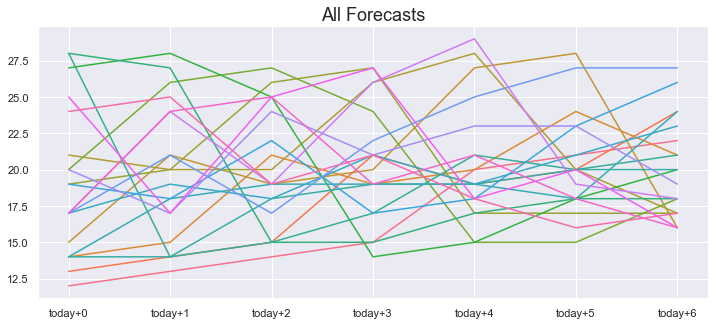

In [18]:
plot_data(temps,"All Forecasts")

The above chart shows a pattern, but isn't clealy interpretable.

In [19]:
def heat_map(data,title):
    fig, ax = plt.subplots(figsize = (10,10))
    ax = sns.heatmap(data, annot=True, center=True, cmap = 'coolwarm',cbar_kws={'label': 'Degrees Celcius'})
    ax.set_title(title, loc='center', fontsize=18)
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
    ax.figure.axes[-1].yaxis.label.set_size(14)
    ax.figure.axes[0].yaxis.label.set_size(14)
    ax.figure.axes[0].xaxis.label.set_size(14)
    return plt.show();

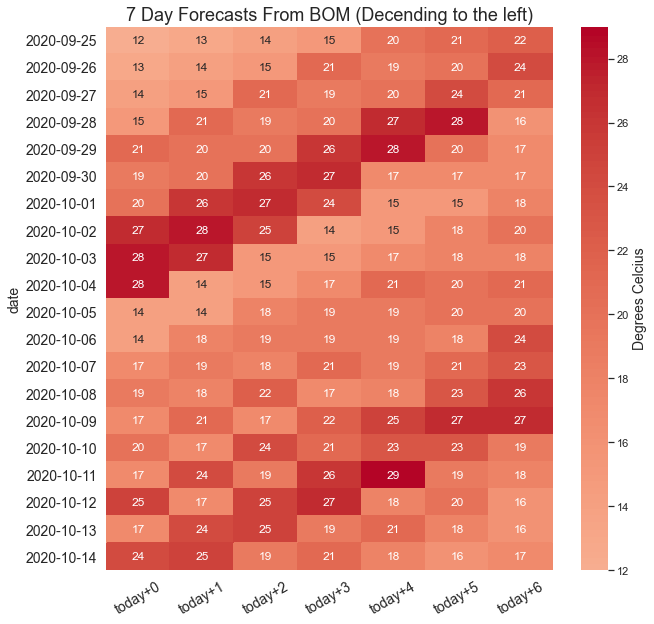

In [20]:
heat_map(temps,"7 Day Forecasts From BOM (Decending to the left)")

**Evaluation: This chart should be read top to bottom, right to left.**       
As the forecast date approaches (decending), the the colour change to the left reflects stregnthening and weaking of systems and the daily adjustment of forecasts.

# PART 3: Evaluate Forecast Accuracy
Check forecast temperature for each day against the recorded temperature for each day.

In [21]:
basic_dates = temps.index # Keep non-datetime index list for charts. (avoid 00:00:00 ending)
temps.index = pd.to_datetime(temps.index) # make index a datetime.

def highlight_diags(data):
    '''Highlight Forecast Lines'''
    attr1 = 'background-color: lightgreen'
    attr2 = 'background-color: salmon'
    attr3 = 'background-color: lightblue'
    
    df_style = data.replace(data.values, '')
    np.fill_diagonal(np.flipud(df_style), attr1)
    np.fill_diagonal(np.flipud(df_style)[2:], attr2)
    np.fill_diagonal(np.flipud(df_style)[4:], attr3)
    return df_style

temps.style.apply(highlight_diags, axis=None)

,today+0,today+1,today+2,today+3,today+4,today+5,today+6
date,,,,,,,
2020-09-25 00:00:00,12,13,14,15,20,21,22
2020-09-26 00:00:00,13,14,15,21,19,20,24
2020-09-27 00:00:00,14,15,21,19,20,24,21
2020-09-28 00:00:00,15,21,19,20,27,28,16
2020-09-29 00:00:00,21,20,20,26,28,20,17
2020-09-30 00:00:00,19,20,26,27,17,17,17
2020-10-01 00:00:00,20,26,27,24,15,15,18
2020-10-02 00:00:00,27,28,25,14,15,18,20
2020-10-03 00:00:00,28,27,15,15,17,18,18


The date being forecast shifts down and to the left as the date approaches.   
Note, the highlighting does not appear on GitHub. Please view file here. [Please view file here](https://github.com/bfgdigital/BOM_Weather/tree/main/assets/forecast_highlighting.png)


In [22]:
# Acuracy Mechanism: Compare forecast to actual Temp.
fac = pd.DataFrame()
counter = list(range(len(temps)))
columns = list(temps.columns)

for i in counter:
    # 7 day forecast inc today, so len can't exceed 7
    if i < 7:
        window = i 
        j = i
    else: 
        window = 6
        j = 6
    
    # Start date at most recent row
    actual_date = temps.index[-1] # start with the last day
    window_date = actual_date - pd.DateOffset(days=window) # Number of days in the past can't be more than those forecast
    row_0 = temps.index[0] # We want to end when window date is equal to row_0.
    
    temps_list = [] # temporary holder of weeeks values.
    while window_date >= row_0:
        true_temp = int(temps.loc[actual_date][0]) # True temperature recorded on day
        predicted_temp = int(temps.loc[window_date][window]) # data predicted on value of window
        difference =  true_temp - predicted_temp
        # loop 
        actual_date -= pd.DateOffset(days=1) # take off 1 day.
        window_date -= pd.DateOffset(days=1) # take off 1 day.
        # append
        temps_list.append(difference)    
    # Add list to df as series    
    fac[columns[j]] = pd.Series(temps_list[::-1]) # Add list backwards.
        
fac.index = basic_dates
fac, temps

(            today+0  today+1  today+2  today+3  today+4  today+5  today+6
 date                                                                     
 2020-09-25        0      0.0      0.0      0.0      1.0     -2.0     -2.0
 2020-09-26        0      0.0      0.0      0.0      0.0      0.0      3.0
 2020-09-27        0      0.0      0.0      0.0      0.0      3.0      7.0
 2020-09-28        0      0.0      0.0      0.0      0.0      0.0     12.0
 2020-09-29        0     -1.0      0.0      1.0      0.0      8.0     -3.0
 2020-09-30        0      0.0      1.0      1.0     11.0     -3.0     -3.0
 2020-10-01        0      1.0      1.0      4.0     -1.0     -1.0     -1.0
 2020-10-02        0      0.0      3.0      0.0     -1.0     -1.0     -1.0
 2020-10-03        0      1.0     -1.0     -1.0      0.0      1.0     -1.0
 2020-10-04        0      0.0     -1.0      0.0     -2.0     -3.0     -1.0
 2020-10-05        0      0.0     -1.0      0.0     -2.0      0.0     -3.0
 2020-10-06        0     

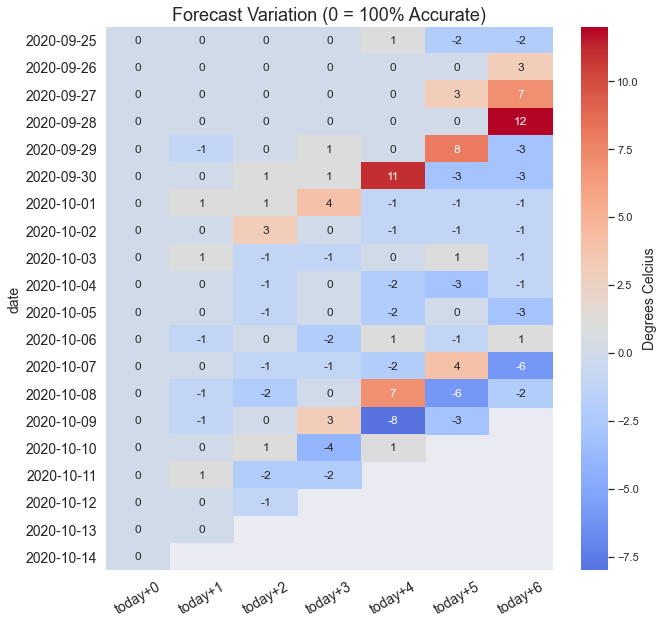

In [23]:
heat_map(fac,"Forecast Variation (0 = 100% Accurate)")

**Evaluation: This chart should be read top to bottom, right to left.**       
Forecasts are generally accurate out to 3 days, with some error developing from 4 days on wards.  What is noteable is the error surrounding weather events. The largest amount of error occurs during the change in weather, as a front approaches for eg, while stable weather appears to be more easily predicted.

# PART 4: Build Persistence Model
- Build models for  Weather(t+i) = Weather(t)

In [24]:
# Persistance Mechanism subtract each max temp from the one before.
pmodel  = pd.Series([today - yesterday for today,yesterday in zip(temps['today+0'],temps['today+0'][1:])],index=temps.index[:len(temps.index)-1])
pmodel

date
2020-09-25    -1
2020-09-26    -1
2020-09-27    -1
2020-09-28    -6
2020-09-29     2
2020-09-30    -1
2020-10-01    -7
2020-10-02    -1
2020-10-03     0
2020-10-04    14
2020-10-05     0
2020-10-06    -3
2020-10-07    -2
2020-10-08     2
2020-10-09    -3
2020-10-10     3
2020-10-11    -8
2020-10-12     8
2020-10-13    -7
dtype: int64

This shows that the persistance model we have is correct as each value in the list is the sum of the sequential temperature value subtracted. This gives us a baseline for how accurate "Tomorrow's weather will be the same as today" was for the days observed to date.

# PART 5: Compare the two models
- Compare Persistance to the forecasts provided by the BOM

In [25]:
persistence = pd.DataFrame()
persistence['Persistence Accuracy'] = pmodel.values
for i in range(1,7):
    persistence[str(i)+' Day Forecast'] = pd.Series(fac['today+'+str(i)].values)
persistence.index = basic_dates[:len(basic_dates)-1]
persistence

,Persistence Accuracy,1 Day Forecast,2 Day Forecast,3 Day Forecast,4 Day Forecast,5 Day Forecast,6 Day Forecast
date,,,,,,,
2020-09-25,-1,0.0,0.0,0.0,1.0,-2.0,-2.0
2020-09-26,-1,0.0,0.0,0.0,0.0,0.0,3.0
2020-09-27,-1,0.0,0.0,0.0,0.0,3.0,7.0
2020-09-28,-6,0.0,0.0,0.0,0.0,0.0,12.0
2020-09-29,2,-1.0,0.0,1.0,0.0,8.0,-3.0
2020-09-30,-1,0.0,1.0,1.0,11.0,-3.0,-3.0
2020-10-01,-7,1.0,1.0,4.0,-1.0,-1.0,-1.0
2020-10-02,-1,0.0,3.0,0.0,-1.0,-1.0,-1.0
2020-10-03,0,1.0,-1.0,-1.0,0.0,1.0,-1.0


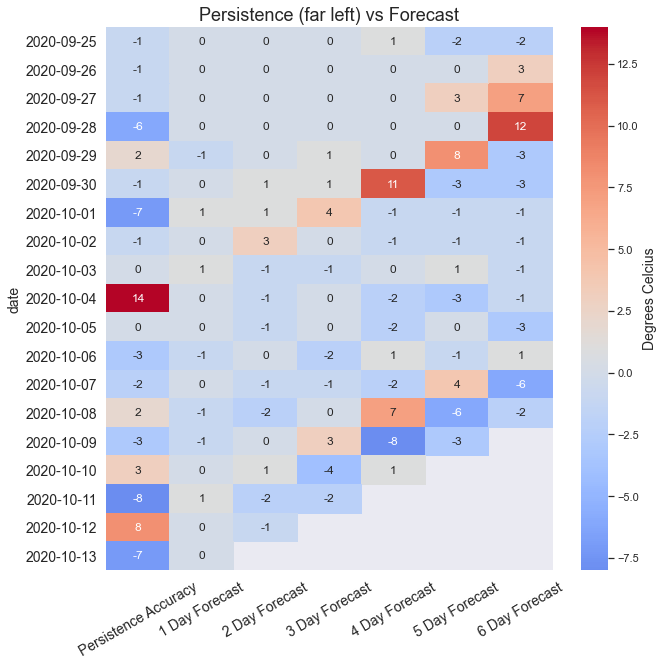

In [26]:
heat_map(persistence,"Persistence (far left) vs Forecast")

It appears that the persistance model may be a good benchmark for forecasts greater than 4 days away.   
To summarise, if you were to wager that the weather on a date 5 days from now, would be the closer to that of the day before rather than what the BOM has forecast, you would likely win.   

This suggests the feasibility of using the persistence model as a weighted feature in forecasts.

# PART 6: Can we use the Persistence model as a feature?
THis section wil attemtp to use historical data from the BOM with common forecasting models Facebook Prophet and Random Forest to see if combined with a Persisence model, we can forecast more accurately than the BOM.

## New Forecast
Using cleaned BOM data from EDA.   
[Click here for EDA notebook locally](eda.ipynb#section_id1)   
[Click here for EDA notebook GitHub](https://github.com/bfgdigital/BOM_Weather/blob/main/notebooks/eda.ipynb)

In [27]:
weather = pd.read_csv('../data/weather.csv',infer_datetime_format=True,index_col=0)
weather.tail()

,rainfall_mm,quality_rf,min_temp_c,quality_mint,max_temp_c,quality_maxt,uv_index
date,,,,,,,
2020-10-04,0.0,0.0,14.0,0.0,30.0,0.0,3.0
2020-10-05,13.0,0.0,9.0,0.0,13.0,0.0,2.0
2020-10-06,1.0,0.0,9.0,0.0,13.0,0.0,2.0
2020-10-07,3.0,0.0,10.0,0.0,17.0,0.0,3.0
2020-10-08,5.0,0.0,11.0,0.0,17.0,0.0,3.0


### Build forecast model
Facebook Prophet is a popular and simple timeseries forecsting tool that is particularly effective with seasonal data.   
["fbprophet" documentation can be found here](https://facebook.github.io/prophet/docs/quick_start.html)

In [28]:
from fbprophet import Prophet

In [29]:
# Create a timeseries
start_date = weather['max_temp_c'].index[0] # First data point
end_date = weather['max_temp_c'].index[-1] # Last data point.
print(f'Range begins {start_date} and ends {end_date}.')

Range begins 2013-06-02 and ends 2020-10-08.


Prophet needs Date and values columns (ds and y)

In [30]:
pdf = pd.DataFrame(None)
pdf['ds'] = weather.index # Create our date column
pdf['y'] = weather['max_temp_c'].values
pdf

,ds,y
0,2013-06-02,16.0
1,2013-06-03,15.0
2,2013-06-04,15.0
3,2013-06-05,15.0
4,2013-06-06,17.0
...,...,...
2681,2020-10-04,30.0
2682,2020-10-05,13.0
2683,2020-10-06,13.0
2684,2020-10-07,17.0


### Observations.
- Data goes all the way back to 2013 recorded daily.   

Because we have timeseries data we can resample and smooth the data using a Savgol filter to adjust for big temperature changes that occur suddenly that BOM forecasts appear to struggle with.

                        y                  ds
ds                                           
2013-06-02 00:00:00  16.0 2013-06-02 00:00:00
2013-06-02 06:00:00  15.0 2013-06-02 06:00:00
2013-06-02 12:00:00  15.0 2013-06-02 12:00:00
2013-06-02 18:00:00  15.0 2013-06-02 18:00:00
2013-06-03 00:00:00  15.0 2013-06-03 00:00:00
...                   ...                 ...
2020-10-07 00:00:00  17.0 2020-10-07 00:00:00
2020-10-07 06:00:00  17.0 2020-10-07 06:00:00
2020-10-07 12:00:00  17.0 2020-10-07 12:00:00
2020-10-07 18:00:00  17.0 2020-10-07 18:00:00
2020-10-08 00:00:00  17.0 2020-10-08 00:00:00

[10741 rows x 2 columns]


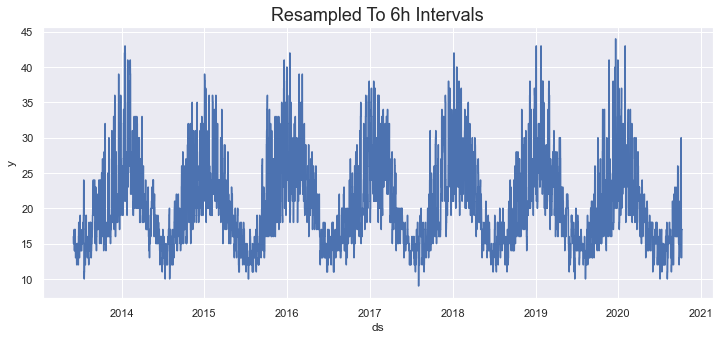

In [31]:
pdf.index = pd.to_datetime(pdf['ds'])
pdf = pdf.resample('6h').mean().bfill() # Resample dates to 6h intervals and back fill.
pdf['ds'] = pdf.index
print(pdf)
plot_data(pdf['y'],"Resampled To 6h Intervals") # plot y
pdf = pdf.reset_index(drop=True) # Perfer to have sequential index for smoothing.

### Smoth Values
- SavGol filter is excellent for smoothing a timeseries data.

This generates smoother curves for the Prophet model to use for interpreting seasonality. Effectively softening outliers.

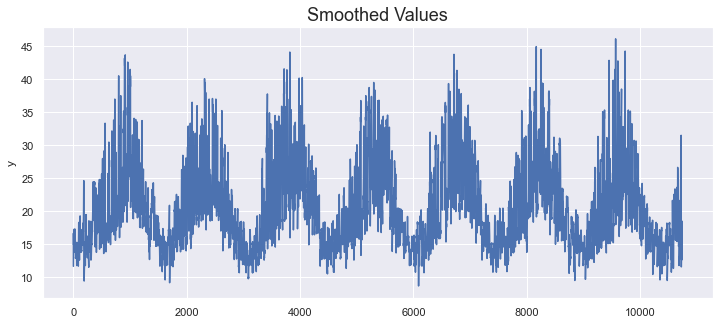

In [32]:
from scipy.signal import savgol_filter
# Smooth with SavGol filter
pdf_sg = pdf
savgol = [savgol_filter(pdf_sg[i], 5, 3, mode='constant') for i in pdf_sg] # modes: 'mirror', 'constant', 'nearest', 'wrap' or 'interp'
savgol = pd.DataFrame(savgol, columns=pd.to_datetime(pdf_sg.index), index=pdf_sg.columns)
savgol = savgol.T # Needed a flip
pdf['y'] = savgol['y']
plot_data(pdf['y'],"Smoothed Values") # plot y

## Use Facebook Prophet to forecast tomorrow's temperature
Facebook Prophet has the ability to detect cycles which may help make more accurate forecasts   
as more data is collected.


 The forecast for tomorrow suggested by Facebook Prophet is: 20.36 



,ds,yhat,yhat_lower,yhat_upper
0,2020-10-09,20.268629,14.723253,26.091643
1,2020-10-10,20.356145,14.529800,25.906165


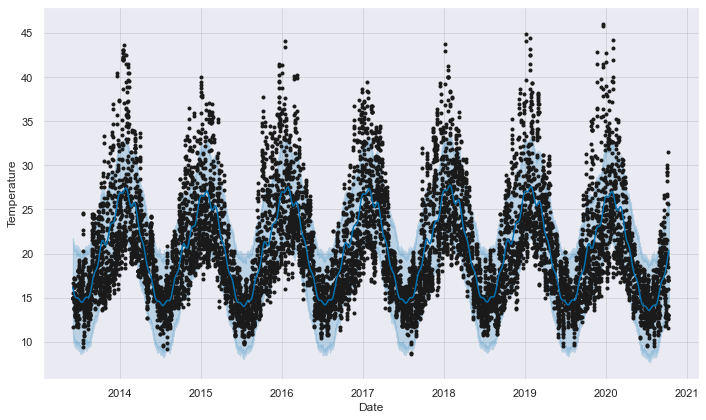

In [33]:
model = Prophet(weekly_seasonality=False)
model.fit(pdf)
future = model.make_future_dataframe(periods = 2) # forecast 2 days beyond available data.
forecast = model.predict(future)
figure = model.plot(forecast, xlabel = 'Date', ylabel = 'Temperature')
print('\n',f"The forecast for tomorrow suggested by Facebook Prophet is: {float(forecast['yhat'][len(forecast)-1]):.2f}",'\n')
prophet_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(2)  # show the dataframe.
prophet_forecast.reset_index(drop=True,inplace=True)
prophet_forecast

Prophet model appears to offer reasonable values.   
Next to check the identified components.

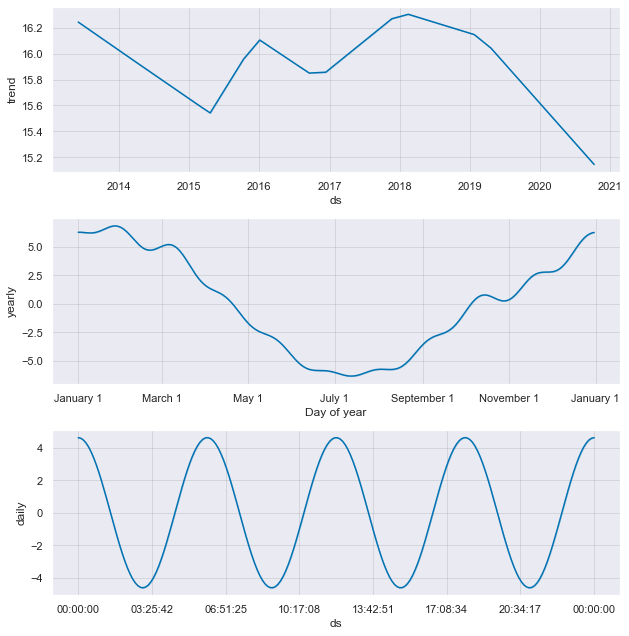

In [34]:
model.plot_components(forecast);

This looks promising, the Yearly trends look accurate the daily trend introduced by the Savgol filter looks to represent overnight temperature fluctuations of around 8º and the trend is based on the latest observations.

## Forecast Max Temp with Random Forrest Regressor

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
y = weather['max_temp_c']
X = weather.drop(['max_temp_c'], axis=1)

regr = RandomForestRegressor(max_depth=100, random_state=42)
regr.fit(X, y)

RandomForestRegressor(max_depth=100, random_state=42)

## Fetch today's rainfall, and uv_index from our API forecast

**Assign feature predictors**   
BOM only supplies 2 days worth of UV predictors.

In [37]:
q_rf = 0 # assuming quality data
q_maxt = 0 # assuming quality data
q_mint = 0 # assuming quality data
max_temps_2days = []
min_temps_2days = []
tomorrow_2days = []
rain_2days = []
uv_2days = []
for i in range(1,3):
    max_temps_2days.append(lf['temp_max'][i])
    min_temps_2days.append(lf['temp_min'][i])
    try:
        rain_2days.append(float(lf['rain'][i]['amount']['max'])) # Using Max instead of Max-Min
    except:
        rain_2days.append(0) # Nan value when no rain.
    uv_2days.append(lf['uv'][i]['max_index'])

rf_features = pd.DataFrame([min_temps_2days, max_temps_2days, rain_2days, uv_2days],columns=['today+1','today+2'],index=['MinTemp','MaxTemp','Rain','UV'])
rf_features

,today+1,today+2
MinTemp,17.0,10.0
MaxTemp,25.0,19.0
Rain,10.0,2.0
UV,7.0,7.0


In [38]:
randomforest_forecast = []
for i in rf_features:
    [predicted_mt] = regr.predict([[rf_features.loc['Rain'][i], q_rf, rf_features.loc['MinTemp'][i], q_mint, q_maxt, rf_features.loc['UV'][i]]]) # sbracket both sides to remove from list.
    score = regr.score(X, y) # R^2 (coefficient of determination) regression score function.
    randomforest_forecast.append(predicted_mt)
    print(f"The temperature forecast by the BOM tomorrow is {rf_features.loc['MaxTemp'][i]} and by our model is {predicted_mt:.2f}, with {score:.2f}% accuracy")

The temperature forecast by the BOM tomorrow is 25.0 and by our model is 22.05, with 0.75% accuracy
The temperature forecast by the BOM tomorrow is 19.0 and by our model is 18.46, with 0.75% accuracy


This output also appears to return an acceptable output, however this model is still using future BOM foreast data for rain and uv, which technically means this model is somewhat cheating. It's still an interesting forecast.   
This model could be used with the persistence model of using today's recorded values for rain and uv features, however I will use the persistence model as part of the final model in the next step and don't want to over-weight yesterday's temperatures.

# Putting all the pieces together
Build a new forecast and add it to existing forecasts.

In [39]:
bens_vs_bom = pd.read_csv('../data/ben_vs_bom.csv',infer_datetime_format=True,index_col=0)

In [40]:
tomorrow = latest_forecast['data'][1]['date'][:10] # We want it as a string, not a datetime.
dayafter = latest_forecast['data'][2]['date'][:10] # We want it as a string, not a datetime.

if dayafter in bens_vs_bom.index:
    print(f'Date is already in index, plese try later.')
else:
    # Day 1 Forecasts
    persistence_forecast_1 = int(temps[::-1]['today+0'][0]) # Today's temp
    prophet_forecast_1 = float(prophet_forecast['yhat'][0]) # Prophet temp
    randomforest_forecast_1 = float(randomforest_forecast[0]) # Random Forest temp
    bens_forecast_1 = (persistence_forecast_1 + prophet_forecast_1 + randomforest_forecast_1)/3 # Average of all three guesses.
    BOM_forecast_1 = rf_features.loc['MaxTemp'][0] # BOM forecast
    
    # Day 1 Forecasts
    persistence_forecast_2 = bens_forecast_1 # Yesterday's forecast temp
    prophet_forecast_2 = float(prophet_forecast['yhat'][1]) # Prophet temp
    randomforest_forecast_2 = float(randomforest_forecast[1]) # Random Forest temp
    bens_forecast_2 = (persistence_forecast_2 + prophet_forecast_2 + randomforest_forecast_2)/3 # Average of all three guesses.
    BOM_forecast_2 = rf_features.loc['MaxTemp'][1] # BOM forecast

    forecasts_1 = [persistence_forecast_1, prophet_forecast_1, randomforest_forecast_1, bens_forecast_1, BOM_forecast_1]
    forecasts_2 = [persistence_forecast_2, prophet_forecast_2, randomforest_forecast_2, bens_forecast_2, BOM_forecast_2]
    
    final_set = pd.DataFrame(None,columns=bens_vs_bom.columns)
    final_set.loc[0] = pd.Series(forecasts_1, index=bens_vs_bom.columns)
    final_set.loc[1] = pd.Series(forecasts_2, index=bens_vs_bom.columns)
    final_set.index = [tomorrow,dayafter]
    
    if dayafter in bens_vs_bom.index:
        print(f'File not saved. Date already exists in index, see you tomorrow.')
    else:
        bvb_filename = '../data/forecast_records/bvb_archive_' + today + '.csv'
        bens_vs_bom.to_csv(bvb_filename) # backup file before dropping last value.
        bens_vs_bom.drop(bens_vs_bom.tail(1).index,inplace=True) # drop last row and update. (same as BOM model updates, dropping last value)
        bens_vs_bom = bens_vs_bom.append(final_set)
        bens_vs_bom.to_csv('../data/ben_vs_bom.csv') # backup file.
        print('File Saved, Thanks for coming.')

Date is already in index, plese try later.


Forecast is built.

### So to wrap up, what do our models forecast the weather will be tomorrow?

In [41]:
bens_vs_bom.style.set_properties(**{'background-color': 'yellow'}, subset=['Bens Best Guess'])

,Persistence,Prophet,RandomForest,Bens Best Guess,BOM Forecast
2020-10-08,17.000000,19.795738,21.860317,19.552018,21
2020-10-09,21.000000,19.795738,19.242409,20.012716,17
2020-10-10,17.000000,20.256093,22.889000,20.048364,24
2020-10-12,24.000000,20.256093,26.301071,23.519055,17
2020-10-13,17.000000,20.256093,17.903000,18.386364,24
2020-10-14,24.000000,20.268629,22.050000,22.106210,25
2020-10-15,22.106210,20.356145,18.462500,20.308285,19


## Conclusion: 
#### The forecast is close, but get your weather forecast from the weather channel.

The End.